# Landcover Summary by Parcel

Getting landcover characteristic summary stats for parcels in Allegeny County.

---

*Notebook prep*

In [1]:
import json
from copy import copy

# ArcGIS API for Python - for accessing 3RWW's open reference datasets in ArcGIS Online
from arcgis.gis import GIS, Layer
from arcgis.raster import ImageryLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis import geometry

# rasterio, for reading rasters from S3
import rasterio
from rasterio.coords import BoundingBox
from rasterio import windows, warp, mask
import rasterio.plot as rplot

# Pandas
import pandas as pd

# Numpy
import numpy as np

# for displaying things from the ArcGIS Online in this Jupyter notebook
from IPython.display import display

# for displaying COGs from S3 buckets
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

## Resources and Constants

In [2]:
epsg_code = 3857 # web mercator

#### Parcels on the Allegheny County AGOL

In [3]:
alcogis = GIS('https://alcogis.maps.arcgis.com')

# parcels dataset - AGOL item ID
alco_parcels_id = 'ebc3eb6a71dc4a60839b6eb80fa176aa'

# a test parcel PIN (3RWW's office)
alco_parcel_pin = "0049K00062000000"

#### Landcover Data on AWS S3

In [4]:
# test UTC from Allegheny County. Store in an AWS S3 bucket 
# as a cloud-optimized GeoTiff (COG)
landcover = "https://3rww-rainways.s3.us-east-2.amazonaws.com/data/landcover_2010_alleghenycounty_cog.tif" # elevation

## Retrieve and Visualize the Landcover Data

Let's take a quick look at our landcover data and demonstrate some of the things we can do with `rasterio`.

First we'll read in a downsampled version of the data--something enabled by the COG format--and draw it on a map, and show how we can think about data windows.

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 65536, 'height': 62464, 'count': 1, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.194328566955879, 0.0, -8946801.28672331,
       0.0, -1.194328566955879, 4965960.853631329)}
(1249, 1310)
Window(col_off=550, row_off=475, width=50, height=50)


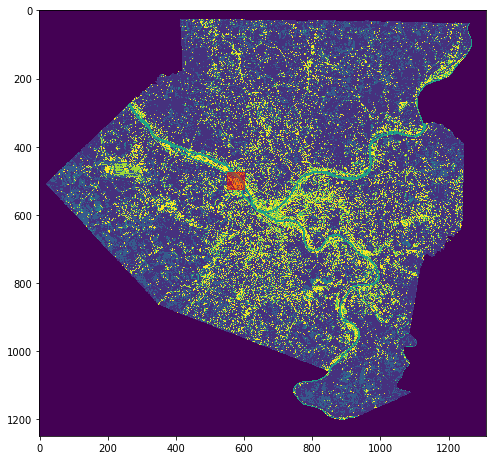

In [20]:

with rasterio.Env(CPL_CURL_VERBOSE=True):
    with rasterio.open(landcover) as src:
        
        # -------------------------------------------------------
        # print some info about the raster
        print(src.meta)
        
        # -------------------------------------------------------
        # read a preview data, with its nodata mask applied
        # for the purposes of previewing, we'll read a 50:1 overview of the raster
        out_shape=(src.height//50, src.width//50)
        print(out_shape)
        arr = src.read(out_shape=out_shape, masked=True)

        # -------------------------------------------------------
        # show a the location of a window of the data
        slice_ = (slice(475, 525), slice(550, 600))
        window_slice = windows.Window.from_slices(*slice_)
        print(window_slice)
        
        # -------------------------------------------------------
        # preview the data and the window
        
        %matplotlib inline
        plt.figure(figsize=(8,8))
        plt.imshow(arr[0])
        
        ax = plt.gca()
        ax.add_patch(
            Rectangle(
                (window_slice.col_off, window_slice.row_off),
                width=window_slice.width,
                height=window_slice.height,
                fill=True,
                alpha=.5,
                color="red"
            )
        )
        
        plt.show()


### read a window of data

Note that we're doing this on the full resolution raster:

Window(col_off=20000, row_off=20000, width=1000, height=1000)
(1, 1000, 1000)


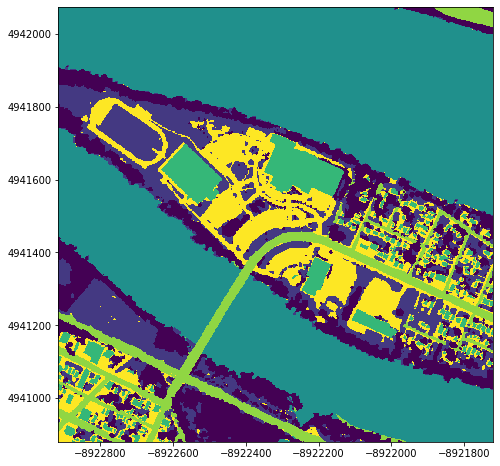

In [21]:
with rasterio.open(landcover) as src:

    # -------------------------------------------------------
    # show a the location of a window of the data
    window_slice = windows.Window.from_slices(slice(20000, 21000), slice(20000, 21000))
    print(window_slice)    
    
    transform_window = windows.transform(window_slice, src.transform)
    arr = src.read(window=window_slice, masked=True)

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr[0],
        transform=transform_window,
    )

That demonstrates the mechanics of getting the raster. Now, onto what the end-to-end workflow looks like.

## Get the parcel

This is the first actual step. We query the parcel, and get its geometry and bounding box.

In [7]:
parcels_item = alcogis.content.get(itemid=alco_parcels_id)
parcels_layer = parcels_item.layers[0]

In [8]:
parcel = parcels_layer.query(
    where="PIN='{0}'".format(alco_parcel_pin),
    outFields='MAPBLOCKLOT,CALCACREAGE,PIN',
    outSR=epsg_code
)

Note that we've requested this data in the same CRS that we know the elevation raster is stored in. It's likely going to be faster to transform the coordinates of a vector polygon than reprojecting an entire raster on the fly.

That response from the ArcGIS API for Python comes back as a a FeatureSet object. Get that response into GeoJSON (as a plain old Python dictionary).

In [9]:
parcel_geojson = json.loads(parcel.to_geojson)
parcel_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-8901207.331349105, 4933808.8143591555],
      [-8901057.521040685, 4933951.6462321775],
      [-8900896.645649388, 4933783.1762194615],
      [-8901133.616647175, 4933731.445691026],
      [-8901207.331349105, 4933808.8143591555]]]},
   'properties': {'MAPBLOCKLOT': '49-K-62',
    'CALCACREAGE': 5.03,
    'PIN': '0049K00062000000',
    'OBJECTID': 1}}]}

Also get the bounding box. Note that this approach is unique to dealing with the ArcGIS API for Python; we could also get a bounding box by reading the GeoJSON created above into GeoPandas. 6 vs 1/2 dozen at this point.

In [10]:
parcel_bbox = list(GeoAccessor(parcel.sdf).bbox.extent)
parcel_bbox

[-8901207.331349105, 4933731.445691026, -8900896.645649388, 4933951.6462321775]

In [11]:
GeoAccessor(parcel.sdf).area

35182.05449743371

## Get the landcover data where it intersects the parcel.

First let's try using just the bounding box. In this case, the bounding box becomes the source of the `window` argument to rasterio's `.read` method after a transformation is applied.

Window(col_off=38175.38710508775, row_off=26801.006259723566, width=260.13419448491186, height=184.37182802474126)
1 7 3.9220526755852845
(1, 184, 260)


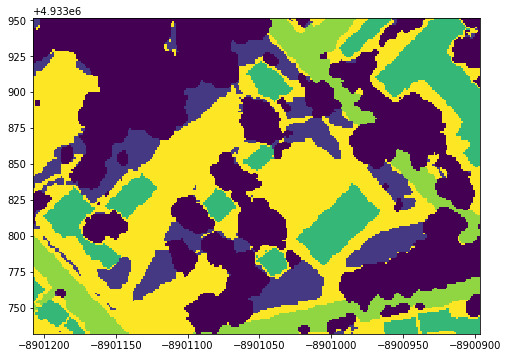

In [12]:
with rasterio.open(landcover) as src:

    # show a the location of a window of the data
    window_slice = windows.from_bounds(*parcel_bbox, src.transform)
    print(window_slice)
    
    transform_window = windows.transform(window_slice, src.transform)
    
    # read the data in at just the bbox
    arr = src.read(window=window_slice, masked=True)
    
    print(arr.min(), arr.max(), arr.mean())

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr[0],
        transform=transform_window
    )



Next let's try using the parcel as a clipping mask:

1 7 4.034626768844017
(1, 185, 261)


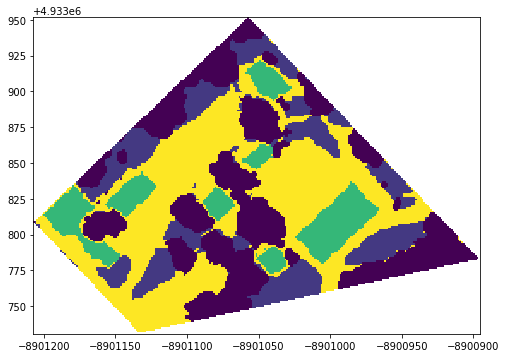

In [13]:
with rasterio.open(landcover) as src:

    # read just the geometry of the parcel feature(s)
    # we only have one here, but this works on an array.
    shapes = [f["geometry"] for f in parcel_geojson['features']]
    
    # read the data in using rasterio's mask function
    arr, out_transform = rasterio.mask.mask(src, shapes, crop=True, filled=False)
    
    print(arr.min(), arr.max(), arr.mean())

    # plot the data.
    window_slice = windows.from_bounds(*parcel_bbox, out_transform)
    transform_window = windows.transform(window_slice, out_transform)

    print(arr.shape)
    %matplotlib inline
    plt.figure(figsize=(8,8))
    #plt.imshow(arr[0], cmap='bone', transform=transform_window)
    rplot.show(
        arr,
        transform=transform_window
    )



Generate some summary stats. Since this raster is categorical, we start by getting cell counts of unique cell values.

In [14]:
unique, counts = np.unique(arr, return_counts=True)

In [15]:
# cells by landcover class ID
counts_by_code = dict(zip([str(x) for x in list(unique)], list(counts)))
counts_by_code

{'1': 7334, '2': 4637, '5': 2973, '7': 9719, '--': 23622}

Those cell values represent landcover class IDs. Here's the lookup:

In [16]:
# Landcover class code lookup
lc_lookup = {
    '1':"Trees",
    '2':"Shrub",
    '3':"Bare Earth",
    '4':"Open Water",
    '5':"Buildings",
    '6':"Pavement",
    '7':"Other Impervious",
}

Apply the lookup, ditching the null cells (outside of the parcel) in the process.

In [17]:
counts_by_class = {lc_lookup[k]: v for k, v in counts_by_code.items() if k in lc_lookup.keys()}
counts_by_class

{'Trees': 7334, 'Shrub': 4637, 'Buildings': 2973, 'Other Impervious': 9719}

Let's convert those counts to percentages, which is what tools like the National Stormwater Calculator and TR55 use.

In [18]:
# total cells
total_not_null = sum([ct for lc, ct in counts_by_class.items()])
total_not_null

24663

In [22]:
pct_by_class = {lc: round(ct / total_not_null * 100, 1) for lc, ct in counts_by_class.items()}
print(pct_by_class)

{'Trees': 29.7, 'Shrub': 18.8, 'Buildings': 12.1, 'Other Impervious': 39.4}
